Generating the dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, Ridge, Lasso   # used for benchmarking
import pandas as pd    # used to create Latex tables 

In [ ]:
def generateData(nData : int, noise : float) -> tuple[np.array, np.array, np.array, np.array]:
    """
    Generates train and test data for the Runge function
    """
    x = np.linspace(-1, 1, nData)
    y = 1 / (1 + 25*np.pow(x, 2)) + np.random.normal(0, noise, size=nData)

    return train_test_split(normalize(x.reshape(-1, 1), axis=0, norm='max'), y)

In [ ]:


def featureMat(x : np.array, p : int, noIntercept : bool = True) -> np.array:
    """
    Returns a feature matrix of degree p of the given data 
    """
    return x[:, None] ** np.arange(int(noIntercept), p+1)

def MSE(target : np.array, pred : np.array) -> float:
    """
    Computes the MSE from the given prediction and target
    """
    return np.average(np.pow(target - pred, 2))

def R2(target : np.array, pred : np.array) -> float:
    """
    Computes the R2 from the given prediction and target
    """
    ybar = np.average(target)
    denom = np.sum(np.pow(target - ybar, 2))
    
    if denom == 0: return 0.0
    return 1 - np.sum(np.pow(target - pred, 2)) / denom

def testFit(xTest : np.array, yTest : np.array, beta : np.array) -> tuple[float, float]:
    """
    Returns the MSE and R2 of the given input model and data 
    """
    pred = xTest @ beta
    return MSE(yTest, pred), R2(yTest, pred)

In [ ]:
def OLS_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

def generateFitOLS(xTrain : np.array, yTrain : np.array, degree : int) -> np.array:
    X = featureMat(xTrain, degree)
    return OLS_parameters(X, yTrain)

In [5]:
degrees = np.arange(2, 15, 1)
mses = np.zeros_like(degrees, dtype=float)
R2s = np.zeros_like(degrees, dtype=float)

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()

for i, degree in enumerate(degrees):
    beta = generateFitOLS(x_train, y_train, degree)
    mses[i], R2s[i] = testFit(x_test, y_test, beta)
    
plt.plot(degrees, mses, label="MSEs")
plt.plot(degrees, R2s, label="R2")
plt.legend()
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [6]:
mses = np.ndarray((7, 8))

for i, nData in enumerate(range(30, 100, 10)):
    x_train, x_test, y_train, y_test = generateData(nData)
    x_train = x_train.flatten(); x_test = x_test.flatten()
    for j, degree in enumerate(range(2, 10)):
        beta = generateFitOLS(x_train, y_train, degree)
        mses[i, j] = testFit(x_test, y_test, beta)
    
plt.imshow(mses)
plt.title("Grid Points from Meshgrid")
plt.xlabel("Degree")
plt.ylabel("Batchsize")
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [7]:
def getRidgeParam(x : np.array, y : np.array, l : float) -> np.array:
    return np.linalg.inv(l*np.identity(x.shape[1]) + x.T @ x) @ x.T @ y

In [8]:
def generateFitRidge(xTrain : np.array, yTrain : np.array, degree : int, l : float) -> np.array:
    X = featureMat(xTrain, degree)
    return getRidgeParam(X, yTrain, l)

In [9]:
lambdas = np.linspace(0.001, 10, 100)
mses = np.zeros_like(lambdas, dtype=float)
R2s = np.zeros_like(lambdas, dtype=float)
thetas = []

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()

for i, l in enumerate(lambdas):
    beta = generateFitRidge(x_train, y_train, 3, l)
    thetas.append(beta)
    mses[i], R2s[i] = testFit(x_test, y_test, beta)
    
plt.plot(lambdas, mses, label="MSEs")
plt.plot(lambdas, R2s, label="R2")
plt.plot(lambdas, thetas, label=["param1", "param2", "param3", "param4"])
plt.xlabel("Lambda value")
plt.ylabel("Error")
plt.legend()
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

Task c)

In [10]:
class Grads():
    def __init__(self, n, X, y):
        self.temp1 = 2/n * X.T @ X
        self.temp2 = 2/n * X.T @ y

    def gOLS(self, theta): 
        return self.temp1 @ theta - self.temp2


    def gRidge(self, theta, l):
        return self.temp1 @ theta - self.temp2 + 2*l*theta
    
    def gLasso(self, theta, l, X, y):
        return 2/X.shape[0] * (X.T @ X @ theta - X.T @ y) + l*np.sign(theta)

In [11]:
def gradientDescent(x_train, x_test, y_train, y_test, n_features, eta, epoch):
    # Initialize weights for gradient descent
    theta = np.random.rand(n_features)

    mses = np.ndarray(epoch)
    R2s = np.ndarray(epoch)
    thetas = []

    nData = 100

    grads = Grads(nData, featureMat(x_train, n_features, noIntercept=True), y_train)

    # Gradient descent loop
    for t in range(epoch):
        # Compute gradients for OSL and Ridge
        grad_OLS = grads.gOLS(theta)
        # Update parameters theta
        theta = theta - eta * grad_OLS

        thetas.append(theta)
        mses[t], R2s[t] = testFit(x_test, y_test, theta)

    plt.plot(range(epoch), mses, label="MSEs")
    plt.plot(range(epoch), R2s, label="R2")
    plt.plot(range(epoch), thetas)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

x_train, x_test, y_train, y_test = generateData(nData)
x_train = x_train.flatten(); x_test = x_test.flatten()
gradientDescent(x_train, x_test, y_train, y_test, 5, 0.01, 100)

TypeError: featureMat() got an unexpected keyword argument 'noIntercept'

Task d)

In [12]:
def gradientDescent2(x_train, x_test, y_train, y_test, n_features, learningRate, epoch, optimizer="adam", momentum=0, seed=0, decay1=0.9, decay2=0.99):
    if seed != 0: np.random.seed(seed)
    # Initialize weights for gradient descent
    theta = np.random.rand(n_features)

    mses = np.ndarray(epoch)
    R2s = np.ndarray(epoch)
    thetas = []

    epsilon = 10E-8
    lr = learningRate

    grads = Grads(100, featureMat(x_train, n_features, noIntercept=True), y_train)
    lastTheta = theta
    gradsSum = np.zeros_like(theta)
    movingAverage = np.zeros_like(theta)
    movingAverage2 = np.zeros_like(theta)


    # Gradient descent loop
    for t in range(epoch):
        # Compute gradients for OSL and Ridge
        grad_OLS = grads.gOLS(theta)
        # Update parameters theta with momentum 
        if optimizer.lower() == "rmsprop" or optimizer.lower == "adam":
            movingAverage2 = decay2*movingAverage2 + (1-decay2) * np.pow(grad_OLS, 2)
            if optimizer.lower() == "rmsprop":
                theta = theta - lr * grad_OLS / np.sqrt(movingAverage2 + epsilon)
            else:
                movingAverage = (decay1*movingAverage + (1-decay1) * grad_OLS) / (1 - decay1)
                movingAverage2 = movingAverage2 / (1-decay2)
                theta = theta - lr * movingAverage / np.sqrt(movingAverage2 + epsilon)

        else:
            gradsSum += np.pow(grad_OLS, 2)
            theta = theta - lr * grad_OLS + momentum*(theta - lastTheta)

            if optimizer.lower() == "adagrad": lr = learningRate / (np.sqrt(gradsSum)+epsilon)
        
        lastTheta = theta
        
        thetas.append(theta)
        mses[t], R2s[t] = testFit(x_test, y_test, theta)

    plt.plot(range(epoch), mses, label="MSEs")
    plt.plot(range(epoch), R2s, label="R2")
    plt.plot(range(epoch), thetas)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()
gradientDescent2(x_train, x_test, y_train, y_test, 5, 0.01, 1000, momentum=0.0001, optimizer="adam")

TypeError: featureMat() got an unexpected keyword argument 'noIntercept'

Task e)

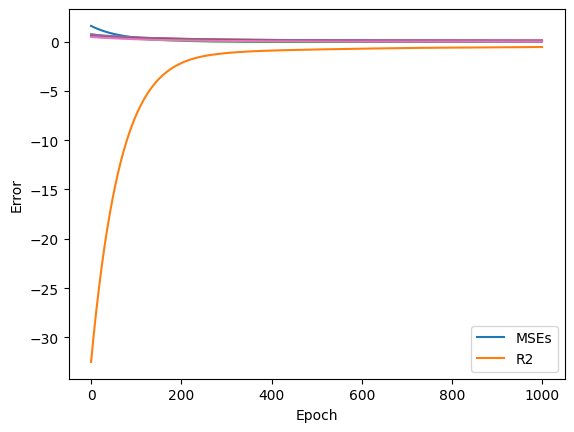

In [ ]:
def gradientDescent3(x_train, x_test, y_train, y_test, n_features, learningRate, epoch, optimizer="adam", momentum=0, seed=0, decay1=0.9, decay2=0.99):
    if seed != 0: np.random.seed(seed)
    # Initialize weights for gradient descent
    theta = np.random.rand(n_features)

    mses = np.ndarray(epoch)
    R2s = np.ndarray(epoch)
    thetas = []

    epsilon = 10E-8
    lr = learningRate

    grads = Grads(100, featureMat(x_train, n_features, noIntercept=True), y_train)
    lastTheta = theta
    gradsSum = np.zeros_like(theta)
    movingAverage = np.zeros_like(theta)
    movingAverage2 = np.zeros_like(theta)


    # Gradient descent loop
    for t in range(epoch):
        # Compute gradients for OSL and Ridge
        grad_OLS = grads.gLasso(theta, 0.01)
        # Update parameters theta with momentum 
        if optimizer.lower() == "rmsprop" or optimizer.lower() == "adam":
            movingAverage2 = decay2*movingAverage2 + (1-decay2) * np.pow(grad_OLS, 2)
            if optimizer.lower() == "rmsprop":
                theta = theta - lr * grad_OLS / np.sqrt(movingAverage2 + epsilon)
            else:
                movingAverage = (decay1*movingAverage + (1-decay1) * grad_OLS) / (1 - decay1)
                movingAverage2 = movingAverage2 / (1-decay2)
                theta = theta - lr * movingAverage / np.sqrt(movingAverage2 + epsilon)

        else:
            gradsSum += np.pow(grad_OLS, 2)
            theta = theta - lr * grad_OLS + momentum*(theta - lastTheta)

            if optimizer.lower() == "adagrad": lr = learningRate / (np.sqrt(gradsSum)+epsilon)
        
        lastTheta = theta
        
        thetas.append(theta)
        mses[t], R2s[t] = testFit(x_test, y_test, theta)

    plt.plot(range(epoch), mses, label="MSEs")
    plt.plot(range(epoch), R2s, label="R2")
    plt.plot(range(epoch), thetas)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()
gradientDescent3(x_train, x_test, y_train, y_test, 5, 0.01, 1000, momentum=0.0001, optimizer="adam")

Task f)

C:\Users\maxfo\AppData\Local\Temp\ipykernel_8592\3673221011.py:31: RuntimeWarning: overflow encountered in divide
  movingAverage2 = movingAverage2 / (1-decay2)
C:\Users\maxfo\AppData\Local\Temp\ipykernel_8592\3673221011.py:30: RuntimeWarning: overflow encountered in divide
  movingAverage = (decay1*movingAverage + (1-decay1) * grad_OLS) / (1 - decay1)
C:\Users\maxfo\AppData\Local\Temp\ipykernel_8592\3673221011.py:32: RuntimeWarning: invalid value encountered in divide
  theta = theta - lr * movingAverage / np.sqrt(movingAverage2 + epsilon)


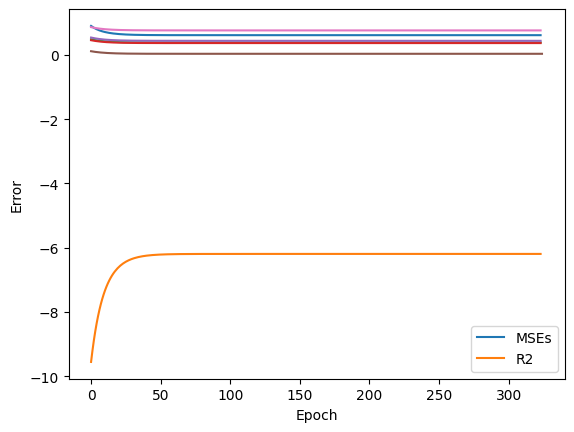

In [ ]:
def gradientDescent4(x_train, x_test, y_train, y_test, n_features, learningRate, epoch, optimizer="adam", momentum=0, seed=0, decay1=0.9, decay2=0.99):
    if seed != 0: np.random.seed(seed)
    # Initialize weights for gradient descent
    theta = np.random.rand(n_features)

    mses = np.ndarray(epoch)
    R2s = np.ndarray(epoch)
    thetas = []

    epsilon = 10E-8
    lr = learningRate

    grads = Grads(100, featureMat(x_train, n_features, noIntercept=True), y_train)
    lastTheta = theta
    gradsSum = np.zeros_like(theta)
    movingAverage = np.zeros_like(theta)
    movingAverage2 = np.zeros_like(theta)


    # Gradient descent loop
    for t in range(epoch):
        x_train_re, y_train_re = resample(x_train, y_train)
        grad_OLS = grads.gLasso(theta, 0.01, featureMat(x_train_re, n_features, noIntercept=True), y_train_re.flatten())
        # Update parameters theta with momentum 
        if optimizer.lower() == "rmsprop" or optimizer.lower() == "adam":
            movingAverage2 = decay2*movingAverage2 + (1-decay2) * np.pow(grad_OLS, 2)
            if optimizer.lower() == "rmsprop":
                theta = theta - lr * grad_OLS / np.sqrt(movingAverage2 + epsilon)
            else:
                movingAverage = (decay1*movingAverage + (1-decay1) * grad_OLS) / (1 - decay1)
                movingAverage2 = movingAverage2 / (1-decay2)
                theta = theta - lr * movingAverage / np.sqrt(movingAverage2 + epsilon)

        else:
            gradsSum += np.pow(grad_OLS, 2)
            theta = theta - lr * grad_OLS + momentum*(theta - lastTheta)

            if optimizer.lower() == "adagrad": lr = learningRate / (np.sqrt(gradsSum)+epsilon)
        
        lastTheta = theta
        
        thetas.append(theta)
        mses[t], R2s[t] = testFit(x_test, y_test, theta)

    plt.plot(range(epoch), mses, label="MSEs")
    plt.plot(range(epoch), R2s, label="R2")
    plt.plot(range(epoch), thetas)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()
gradientDescent4(x_train, x_test, y_train, y_test, 5, 0.01, 1000, momentum=0.0001, optimizer="adam")

Learning and gradient descent fixed

In [ ]:
class Optimizers: 
    class ADAM:
        """
        Implmenets the ADAM optimizer
        """
        def __init__(self, learningRate : float, decay1 : float, decay2 : float, n : int) -> None:
            self.beta1 = decay1
            self.beta2 = decay2
            self.lr = learningRate
            self.m = np.zeros(n)
            self.v = np.zeros(n)
            self.epsilon = 1E-8
            self.t = 0

        def __call__(self, theta : np.array, gradient : np.array) -> np.array:
            self.t += 1
            self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
            self.v = self.beta2 * self.v + (1 - self.beta2) * (gradient ** 2)
            m_hat = self.m / (1 - self.beta1 ** self.t)
            v_hat = self.v / (1 - self.beta2 ** self.t)
            theta = theta - self.lr * m_hat / np.sqrt(v_hat + self.epsilon)
            return theta
        
        def __str__(self) -> str: return "ADAM"

    class RMSprop:
        """
        Implmenets the RMSprop optimizer
        """
        def __init__(self, learningRate : float, decay : float, n : int) -> None:
            self.lr = learningRate
            self.decay = decay
            self.movingAverage2 = np.zeros(n)
            self.epsilon = 1E-8

        def __call__(self, theta : np.array, gradient : np.array) -> np.array:
            self.movingAverage2 = self.decay*self.movingAverage2 + (1-self.decay) * np.pow(gradient, 2)
            theta = theta - self.lr * gradient / np.sqrt(self.movingAverage2 + self.epsilon)
            return theta
        
        def __str__(self) -> str: return "RMSprop"

    class ADAgrad:
        """
        Implements the ADAgrad optimizer
        """
        def __init__(self, learningRate : float, n : int) -> None:
            self.learningRate = learningRate
            self.gradSum = np.zeros(n)
            self.epsilon = 1E-8

        def __call__(self, theta : np.array, gradient : np.array) -> np.array:
            self.gradSum = self.gradSum + np.pow(gradient, 2)
            lr = self.learningRate / (np.sqrt(self.gradSum)+self.epsilon)
            theta = theta - lr * gradient
            return theta
        
        def __str__(self) -> str: return "ADAgrad"

    class Simple:
        """
        Simple gradient descent with constant learningrate. 
        """
        def __init__(self, learningRate : float) -> None:
            self.learningRate = learningRate

        def __call__(self, theta : np.array, gradient : np.array) -> np.array:
            return theta - self.learningRate * gradient
        
        def __str__(self) -> str: return "No optimizer"

    class Momentum:
        """
        Implements gradient descent with momentom
        """
        def __init__(self, learningRate : float, momentum : float) -> None:
            self.learningRate = learningRate
            self.momentum = momentum
            self.lastTheta = None
        
        def __call__(self, theta : np.array, gradient : np.array) -> np.array:
            self.lastTheta = theta
            return theta - self.learningRate * gradient + self.momentum*(theta - self.lastTheta)
        
        def __str__(self) -> str: return "Momentum"


In [39]:
class Gradients:
    class OLS:
        """
        For computing the gradient for OLS
        """
        def __call__(self, theta : np.array, X : np.array, y : np.array) -> np.array:
            return 2/X.shape[0] * (X.T @ X @ theta - X.T @ y)
        
        def __str__(self) -> str: return "OLS  "
        
    class Ridge:
        """
        For computing the gradient for Ridge
        """
        def __init__(self, l : float) -> None:
            self.l = l

        def __call__(self, theta : np.array, X : np.array, y : np.array) -> np.array:
            return 2/X.shape[0] * (X.T @ X @ theta - X.T @ y) + 2*self.l*theta
        
        def __str__(self) -> str: return "Ridge"
    
    class Lasso:
        """
        For computing the gradient for Lasso
        """
        def __init__(self, l : float) -> None:
            self.l = l

        def __call__(self, theta : np.array, X : np.array, y : np.array) -> np.array:
            return 2/X.shape[0] * (X.T @ X @ theta - X.T @ y) + self.l*np.sign(theta)
        
        def __str__(self) -> str: return "Lasso"

In [40]:
class GradientDescent:
    """
    Keeps and updates the parameters optimized by gradient descent.
    """
    def __init__(self, n_features : int) -> None:
        self.n_features = n_features

        # Initialize weights for gradient descent
        self.theta = np.random.rand(n_features)

    def setOptimizer(self, optimizer : Optimizers) -> None:
        self.optimizer = optimizer

    def setGradient(self, gradient : Gradients) -> None:
        self.gradient = gradient

    def forward(self, x_train : np.array, y_train : np.array) -> np.array:
        gradient = self.gradient(self.theta, x_train, y_train)
        self.theta = self.optimizer(self.theta, gradient)
        return self.theta

Training done!
Trained for 99 epoch with learning rate 0.05,            the model used 4 features,            optimizer ADAM and gradient Ridge.
            The best MSE was 0.047 and was achived after 34 epochs.            The final MSE was 0.050.


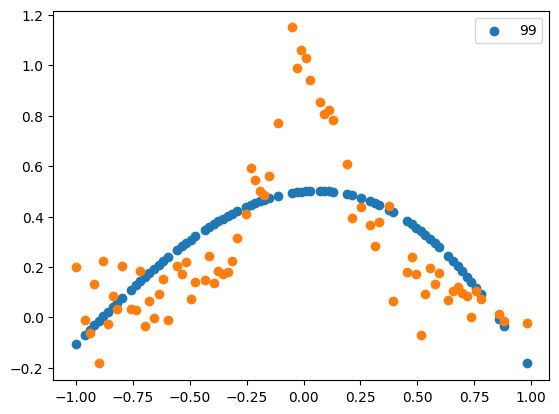

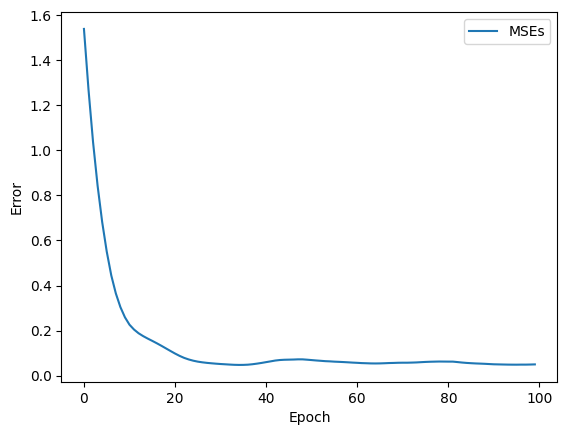

In [ ]:
def singleTraining(epoch : int, learningRate : float, n_features : int, stochasticGD : bool):
    # Sets seed for all random processes so that the code is deterministic 
    np.random.seed(1)

    x_train, x_test, y_train, y_test = generateData(100)
    x_train = x_train.flatten(); x_test = x_test.flatten()

    minChange = min(learningRate/1000, 0.001)  # sets the minimum change in MSE before early stopping
    numDiffs = 10 # sets number of consecutive steps that must change less than this minimum change
    mseDiffs = np.ones(numDiffs)  # keeps track of MSE diferences for early stopping 

    noIntercept = False

    # for logging
    mses = np.zeros(epoch)
    R2s = np.zeros(epoch)
    thetas = []

    featuresWithIntercept = n_features+int(not noIntercept)

    gd = GradientDescent(featuresWithIntercept)
    #gd.setOptimizer(Optimizers.RMSprop(learningRate, 0.99, n_features+int(not noIntercept)))
    #gd.setOptimizer(Optimizers.ADAgrad(learningRate, n_features+int(not noIntercept)))
    gd.setOptimizer(Optimizers.ADAM(learningRate, 0.9, 0.999, featuresWithIntercept))
    g = Gradients.Ridge(0.01)
    gd.setGradient(g)

    x_test = featureMat(x_test, n_features, noIntercept=noIntercept)

    # Gradient descent loop
    for t in range(epoch):
        if (stochasticGD): # stochastic gradient descent 
            x_train_re, y_train_re = resample(x_train, y_train)
            y_train_re = y_train_re.flatten()
            theta = gd.forward(featureMat(x_train_re, n_features, noIntercept=noIntercept), y_train_re)
        else: # normal gradient descent
            theta = gd.forward(featureMat(x_train, n_features, noIntercept=noIntercept), y_train)

        # log the theta, mse and R2
        thetas.append(theta)
        mses[t], R2s[t] = testFit(x_test, y_test, theta)

        # Early stopping
        mseDiffs[t%numDiffs] = abs(mses[t]-mses[t-1])
        if (np.all(mseDiffs < minChange)):
            break
    print(f"Training done!\nTrained for {t} epoch with learning rate {learningRate},\
            the model used {n_features} features,\
            optimizer {gd.optimizer} and gradient {gd.gradient}.\n\
            The best MSE was {mses.min():.3f} and was achived after {np.where(mses == mses.min())[0][0]} epochs.\
            The final MSE was {mses[-1]:.3f}.")

    # model plot
    plt.scatter(x_train, featureMat(x_train, n_features, noIntercept=noIntercept)@thetas[-1], label=t)
    plt.scatter(x_train, y_train)
    plt.legend()
    plt.show()

    # MSE plot
    plt.plot(range(epoch), mses, label="MSEs")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

singleTraining(100, 0.05, 4, True)

Loop for testing all params

In [117]:
np.random.seed(1)

x_train, x_test, y_train, y_test = generateData(100)
x_train = x_train.flatten(); x_test = x_test.flatten()

epoch = 100
learningRate = 0.05

minChange = min(learningRate/1000, 0.001) # sets the minimum change in MSE before early stopping
numDiffs = 10 # sets number of consecutive steps that must change less than this minimum change

noIntercept = False

n_featuresList = [2, 4, 6] # searchspace for model complexity 

logs = []
logs.append("Optimizer                Gradient        Number epoch      Last MSE")

msesTables = []
convergenceTables = []

# loops through the different model complexities to try 
for n_features in n_featuresList:
    logs.append(f"Numb features: {n_features}")

    # Define the search space for this number of features 
    featuresWithIntercept = n_features+int(not noIntercept)
    gradients = [Gradients.OLS(), 
                 Gradients.Ridge(0.01), 
                 Gradients.Lasso(0.01)]
    optimizers = [Optimizers.Simple(learningRate),
                  Optimizers.ADAM(learningRate, 0.9, 0.999, featuresWithIntercept),
                  Optimizers.RMSprop(learningRate, 0.99, featuresWithIntercept),
                  Optimizers.ADAgrad(learningRate, featuresWithIntercept),
                  Optimizers.Momentum(learningRate, 0.9)]
    
    # get all pairs of gradient-optimizer combinations 
    combinations = [(grad, opt) for grad in gradients for opt in optimizers]

    allMses = np.zeros((len(optimizers), len(gradients)))
    finalEpoch = np.zeros((len(optimizers), len(gradients)))
    
    gd = GradientDescent(featuresWithIntercept)
    counter = 0
    for comb in combinations:
        gd.setOptimizer(comb[1])
        gd.setGradient(comb[0])

        x_test_feat = featureMat(x_test, n_features, noIntercept=noIntercept)

        # for logging
        mses = np.zeros(epoch)
        R2s = np.zeros(epoch)
        thetas = []

        # keeps track of MSE diferences for early stopping 
        mseDiffs = np.ones(numDiffs)

        # Gradient descent loop
        for t in range(epoch):
            theta = gd.forward(featureMat(x_train, n_features, noIntercept=noIntercept), y_train)

            # logging
            thetas.append(theta)
            mses[t], R2s[t] = testFit(x_test_feat, y_test, theta)

            # Early stopping
            mseDiffs[t%numDiffs] = abs(mses[t]-mses[t-1])
            if (np.all(mseDiffs < minChange)):
                break

        logs.append(f"Opt: {str(comb[1]):14}      grad: {str(comb[0])}      epoch: {t:3}      mse: {mses[t]:.4f}")
        
        allMses[counter%len(optimizers)][int(counter / len(optimizers))] = mses[t]
        finalEpoch[counter%len(optimizers)][int(counter / len(optimizers))] = t
        
        counter += 1
    
    convergenceTables.append(pd.DataFrame(finalEpoch, index=optimizers, columns=gradients))
    msesTables.append(pd.DataFrame(allMses, index=optimizers, columns=gradients))


file_path = "MSETables.tex"
with open(file_path, "w") as f:
    f.write("\\newcommand{\\results}{\n")
    for i, table in enumerate(msesTables, start=0):
        f.write(f"% ---- {n_featuresList[i]} features ----\n")
        f.write(f"\\begin{{table}}[H]\n\\centering\n\\caption{{Final test MSE for gradient descent. Showing gradient-optimizer combinations with {n_featuresList[i]} features.}}\n"+"\\label{tab:training_mse"+str(n_featuresList[i])+"}")
        f.write(table.to_latex(float_format="%.4f"))
        f.write("\\end{table}\n\n")
    f.write("}\n")

file_path = "EpochTables.tex"
with open(file_path, "w") as f:
    for i, table in enumerate(convergenceTables, start=0):
        f.write(f"\n% ---- {n_featuresList[i]} features ----\n")
        f.write(f"\\begin{{table}}[H]\n\\centering\n\\caption{{Number of epoch need for convergence for gradient-optimizer combinations with {n_featuresList[i]} features.}}\n"+"\\label{tab:final_epoch"+str(n_featuresList[i])+"}")
        f.write(table.to_latex(float_format="%d"))
        f.write("\\end{table}\n")

# save logs to file
with open("out.txt", "w") as outfile:
    outfile.write("\n".join(logs))

Benchmark code

In [ ]:
n_featuresList = [2, 4, 6] # searchspace for model complexity 
mses = np.zeros((3, len(n_featuresList)))

for i, n_features in enumerate(n_featuresList):
    x_test_feat = featureMat(x_test, n_features, noIntercept=noIntercept)
    x_trian_feat = featureMat(x_train, n_features, noIntercept=noIntercept)

    ols = LinearRegression(fit_intercept=True)
    ols.fit(x_trian_feat, y_train)
    mses[0][i] = MSE(ols.predict(x_test_feat), y_test)


    ridge = Ridge(alpha=0.01)
    ridge.fit(x_trian_feat, y_train)
    mses[1][i] = MSE(ridge.predict(x_test_feat), y_test)

    lasso = Lasso(alpha=0.01)
    lasso.fit(x_trian_feat, y_train)
    mses[2][i] = MSE(lasso.predict(x_test_feat), y_test)

df = pd.DataFrame(mses, index=["OLS", "Ridge", "Lasso"], columns=n_featuresList)

file_path = "MSETables.tex"
with open(file_path, "a") as f:
    f.write("\\newcommand{\\benchMark}{\n")
    f.write(f"% ---- Benchmark values ----\n")
    f.write(f"\\begin{{table}}[H]\n\\centering\n\\caption{{Test MSEs from closed form solutions. Gradient plotted against number of features.}}\n"+"\\label{tab:benchMarkMSE}")
    f.write(df.to_latex(float_format="%.4f"))
    f.write("\\end{table}\n")
    f.write("}")